In [1]:
""" LEVEL 1 QC: Remove bottom, large error velocity and upward velocity from the merged raw-ADCP data
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_time import datetime_to_yearday
from bipolar import bipolar

In [2]:
### Specify merged Saildrone merged adcp nc file
year = '2023'
platf_num = '1042'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'

### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
timestamp_cur_SD = np.array([dtime_cur_SD[i].timestamp() for i in range(len(dtime_cur_SD))])
_, yday_cur_SD = datetime_to_yearday( dtime_cur_SD )
vars_str = ['longitude','latitude','vel_east','vel_north','depth','error_vel','vel_up','echo_intensity']
for i in range( len(vars_str) ):
    temp = ds_adcp.variables[vars_str[i]][:]
    temp.filled(np.nan)
    if 'vel' in vars_str[i]:
        temp = 100*temp # convert velocity unit from m/s to cm/s
    exec( vars_str[i]+' = temp')
ds_adcp.close()    
del time
print(year+' SD-'+platf_num+' time:',dtime_cur_SD[0],'~',dtime_cur_SD[-1])
dz_add = 6-depth[0]
depth = depth+dz_add
print(depth)

2023 SD-1042 time: 2023-10-18 00:00:00 ~ 2023-11-15 23:30:00
[  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]


In [3]:
### change the time limits
tlim_plot = [datetime.datetime(int(year),6,12), datetime.datetime(int(year),9,15)]
nt_plot = int((tlim_plot[1]-tlim_plot[0]).days)
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nt_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
print(tticks_label)

['06/12', '06/13', '06/14', '06/15', '06/16', '06/17', '06/18', '06/19', '06/20', '06/21', '06/22', '06/23', '06/24', '06/25', '06/26', '06/27', '06/28', '06/29', '06/30', '07/01', '07/02', '07/03', '07/04', '07/05', '07/06', '07/07', '07/08', '07/09', '07/10', '07/11', '07/12', '07/13', '07/14', '07/15', '07/16', '07/17', '07/18', '07/19', '07/20', '07/21', '07/22', '07/23', '07/24', '07/25', '07/26', '07/27', '07/28', '07/29', '07/30', '07/31', '08/01', '08/02', '08/03', '08/04', '08/05', '08/06', '08/07', '08/08', '08/09', '08/10', '08/11', '08/12', '08/13', '08/14', '08/15', '08/16', '08/17', '08/18', '08/19', '08/20', '08/21', '08/22', '08/23', '08/24', '08/25', '08/26', '08/27', '08/28', '08/29', '08/30', '08/31', '09/01', '09/02', '09/03', '09/04', '09/05', '09/06', '09/07', '09/08', '09/09', '09/10', '09/11', '09/12', '09/13', '09/14']


In [13]:
### create indices of OK data ###
### Might have to play with the numbers below for each drone
cri_weak_echo = 30
cri_strong_echo = 150
grad_echo_max = -5
cri_large_w = 5
cri_ratio_errvel = 0.5
###
iOK_LEV1 = np.ones( echo_intensity.shape, dtype='bool')
iOK_LEV1[:,:,:] = True
''' 
0: pass test - "good data"
1: bottom 
2: weak echo
3: strong echo
4: large upward velocity
5: large ration of err velocity to total velocity
'''
str_flags_vel = ['PASS','bottom','weak echo','strong echo','large w','large err v.']
str_flags = [str(i) for i in range(len(str_flags_vel))]
str_flags_cri = ['',\
                 'gradecho<{:.1f}'.format(grad_echo_max),\
                 'echo<{:.1f}'.format(cri_weak_echo),\
                    'echo>{:.1f}'.format(cri_strong_echo),\
                    'w>{:.1f}'.format(cri_large_w),\
                    'r(errvel)>{:.2f}'.format(cri_ratio_errvel)]
print(str_flags_cri)
print([a+': '+b+'('+c+')' for a,b,c in zip(str_flags,str_flags_vel,str_flags_cri)])
###
flags_vel = np.zeros( vel_east.shape, dtype=int) 
nbeam = 4
dz = 2
for i in range( len(dtime_cur_SD) ):
    for z in range( len(depth)-1 ):
        for j in range( nbeam ):
            ### check echo intensity
            grad_echo = (echo_intensity[i,j,z]-echo_intensity[i,j,z+1])/dz
            if grad_echo< grad_echo_max:
                iOK_LEV1[i,j,z+1:] = False
                flags_vel[i,z+1:] = 1
                break
            if echo_intensity[i,j,z] < cri_weak_echo:
                iOK_LEV1[i,j,z] = False
                flags_vel[i,z] = 2
            if echo_intensity[i,j,z] > cri_strong_echo:
                iOK_LEV1[i,j,z] = False
                flags_vel[i,z] = 3
        ### check criteria for upward velocity
        if np.abs(vel_up[i,z]) > cri_large_w:
            iOK_LEV1[i,:,z] = False
            flags_vel[i,z] = 4
        ### check criteria for error velocity
        velmag = np.sqrt(vel_east[i,z]*vel_east[i,z] + vel_north[i,z]*vel_north[i,z])
        if np.abs(error_vel[i,z])/velmag > cri_ratio_errvel:
            iOK_LEV1[i,:,z] = False
            flags_vel[i,z] = 5
            
### index of echo_intensity to be used
iOK_LEV1_one = np.ones( flags_vel.shape, dtype='bool')
iOK_LEV1_one[:,:] = True
iOK_LEV1_one[flags_vel> 0] = False

['', 'gradecho<-5.0', 'echo<30.0', 'echo>150.0', 'w>5.0', 'r(errvel)>0.50']
['0: PASS()', '1: bottom(gradecho<-5.0)', '2: weak echo(echo<30.0)', '3: strong echo(echo>150.0)', '4: large w(w>5.0)', '5: large err v.(r(errvel)>0.50)']


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_25644/274619905.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  if np.abs(error_vel[i,z])/velmag > cri_ratio_errvel:
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_25644/274619905.py:54: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(error_vel[i,z])/velmag > cri_ratio_errvel:


echo<30_>150_gradecho<-5_w>5.0_r(errv)>0.50
[<matplotlib.colors.LinearSegmentedColormap object at 0x7ff558968d90>, <matplotlib.colors.LinearSegmentedColormap object at 0x7ff558968d90>, <matplotlib.colors.LinearSegmentedColormap object at 0x7ff558968d90>, <matplotlib.colors.LinearSegmentedColormap object at 0x7ff558968d90>, 'nipy_spectral', 'jet']


<Figure size 432x288 with 0 Axes>

<Figure size 1296x936 with 0 Axes>

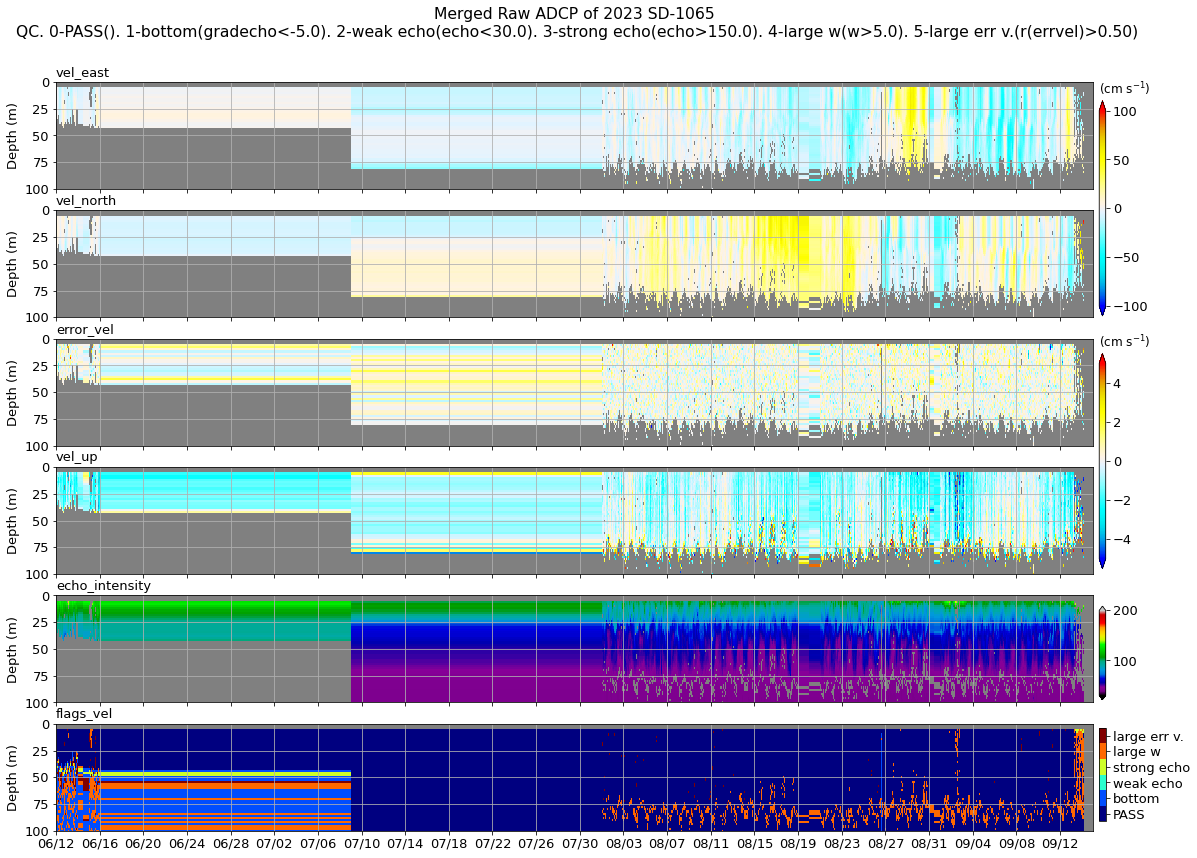

In [14]:
### plot (1) Before and (2) After QC's : u, v, w, error_vel, 1 beam of echo_intensity
isQC = [False, True]
str_QC_crit = 'echo<{:.0f}_>{:.0f}_gradecho<{:.0f}_w>{:.1f}_r(errv)>{:.2f}'.format(cri_weak_echo,cri_strong_echo,grad_echo_max,cri_large_w,cri_ratio_errvel)
print(str_QC_crit)
vars_str = ['vel_east','vel_north','error_vel','vel_up','echo_intensity','flags_vel']
vars_unit_str = ['(cm s$^{-1}$)','(cm s$^{-1}$)','(cm s$^{-1}$)','(cm s$^{-1}$)','',''] 
vellim = [[-100,100],[-100,100],[-5,5],[-5,5],[30,200],[0,5]]
cm_vel = bipolar(neutral=0.95)
cmap = [cm_vel,cm_vel,cm_vel,cm_vel,'nipy_spectral','jet']
print(cmap)
nrow = len(vars_str)
y0_cb = [0.65,0.38,0.24,0.11]
dy_cb = [0.23,0.23,0.1,0.1]
nflags = len(str_flags_vel) # including no flag
###
for iplot in isQC:
    plt.clf()
    fig, ax = plt.subplots(nrows=nrow)
    plt.gcf().set_size_inches(18, 13)
    plt.rcParams.update({'font.size': 13})
    icb = 0
    for i in range( nrow ):
        plt.subplot(nrow,1,i+1)
        ### load variable to plot
        if 'echo' in vars_str[i]:
            var_plot = eval(vars_str[i])[:,0,:].copy()
        else:
            var_plot = eval(vars_str[i]).copy()
        ### flag the data
        if iplot:
            str_QC = 'QC_'+'_'.join([a+'-'+b+'('+c+')' for a,b,c in zip(str_flags,str_flags_vel,str_flags_cri)])
            if 'flags' not in vars_str[i]:
                var_plot[~iOK_LEV1_one] = np.nan
        else:
            str_QC = ''
        if 'flags' not in vars_str[i]:
            cs = plt.pcolormesh(dtime_cur_SD, depth, var_plot.transpose(), cmap=cmap[i],\
                            vmin=vellim[i][0],vmax=vellim[i][1],label=vars_str[i])
        else:
            cmap_flag = plt.get_cmap(cmap[i], nflags)
            cs = plt.pcolormesh(dtime_cur_SD, depth, var_plot.transpose(), cmap=cmap_flag,\
                            vmin=-0.5,vmax=5.5,label=vars_str[i])
        ### figure setting
        plt.xticks(tticks[::4],rotation=0) ### change 
        if i == nrow-1:
            plt.gca().set_xticklabels(tticks_label[::4]) ### change
        else:
            plt.gca().set_xticklabels('')
        plt.xlim(tlim_plot)
        plt.ylim([0,100])
        plt.gca().invert_yaxis()
        plt.grid()
        plt.ylabel('Depth (m)')
        plt.title(vars_str[i],loc='left',fontsize=13)
        plt.gca().set_facecolor('gray')
        ### add colorbar
        if (i == 0) | (i == 2) | (i == 4) :
            cbar_ax = fig.add_axes([.905,y0_cb[icb],.005,dy_cb[icb]])
            axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
            cbar_ax.set_title(vars_unit_str[i],y=1.05,loc='left',fontsize=12)
            icb = icb + 1
        if i == 5: # flag's colorbar
            cbar_ax = fig.add_axes([.905,y0_cb[icb],.005,dy_cb[icb]])
            axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,ticks=np.arange(0,nflags))
            cbar_ax.set_title(vars_unit_str[i],y=1.05,loc='left',fontsize=12)
            cbar_ax.set_yticks(np.arange(0,nflags))
            cbar_ax.set_yticklabels(str_flags_vel)
        
    ###
    plt.suptitle('Merged Raw ADCP of '+year+' SD-'+platf_num+'\n '+str_QC.replace('_','. '))
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.2)
    ### save to figure
    plt.savefig('time-depth_uvw_errvel_echoint_SD'+platf_num+str_QC+'_'+\
                tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')
    # break

In [15]:
n = len(flags_vel.flatten())
for i, flag in enumerate(str_flags_vel):
    icount = np.sum(flags_vel.flatten() == i)
    print('{:.2f}% of data '.format(icount/n*100)+flag)
    if i == 0:
        icount_nan = np.sum((np.isnan(vel_east.flatten())) & (flags_vel.flatten()== i))
        icount_notnan = np.sum((~np.isnan(vel_east.flatten())) & (flags_vel.flatten()== i))
        # print(icount_nan, icount_notnan, icount, icount_nan+icount_notnan)
        print('of which {:.2f}% of '.format(icount_nan/icount*100)+flag+' data is NaN')

87.60% of data PASS
of which 19.84% of PASS data is NaN
3.24% of data bottom
0.00% of data weak echo
0.19% of data strong echo
8.17% of data large w
0.79% of data large err v.


In [10]:
### append data flags (integers) that has the same size to the merged raw adcp file. 
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc','r+',format='NETCDF4')
all_exist_varnms_in_nc = ds_adcp.variables ### this is a dictionary
varnm = 'data_flag'
if varnm not in all_exist_varnms_in_nc.keys():
    print('The existing nc file content:')
    print(ds_adcp)
    ### append new variable
    data_flag = ds_adcp.createVariable(varnm, np.float64, ('time','depth'))
    data_flag.long_name = 'data flags'
    data_flag.units = ''
    data_flag.comment = 'QC: '+'. '.join([a+'-'+b+'('+c+')' for a,b,c in zip(str_flags,str_flags_vel,str_flags_cri)])
    ### writing data to the existing nc file
    data_flag[:,:] = flags_vel
    print('==========')
    print('The new nc file after appending data to it.')
    print(ds_adcp)
else:
    print('==========')
    print('variable already exists so replace/update the variable ('+varnm+'). ')
    ### update variable
    ds_adcp[varnm][:] = flags_vel
    print('The updated nc file after updating the variable ('+varnm+').')
    print(ds_adcp)

ds_adcp.close()

The existing nc file content:
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1065
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
    dimensions(sizes): depth(50), time(11447), beam(4)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 longitude(time), float64 latitude(time), float64 pitch(time), float64 roll(time), float64 heading(time), float64 vehicle_vel_east(time), float64 vehicle_vel_north(time), float64 vehicle_vel_up(time), float64 bt_vel_east(time), float64 bt_vel_north(time), float64 bt_vel_up(time), float64 vel_east(time, depth), float64 vel_north(time, depth), float64 vel_up(time, depth), float64 error_vel(time, depth), float64 percent_good_4_beam(time, depth), float64 percent_good_3_beam(time, depth), float64 percent_good(time, depth), float64 bt_range(time, beam), float64 bt_cor(time, beam), float64 bt_amp(ti